# Is there study bias on proteins with pathogenic mutations?
We are going to explore the relationship between mutations and PTMs.  Specifially, we will test the hypothesis that pathogenic mutations are more likely to have PTMs nearby.  Before we begin, we must first explore what dataset of mutations and proteins we should consider. This code will explore whether there is study bias on proteins with pathogenic mutations, indicating we should control for study bias.

In [1]:
# Setup the workspace, 
from proteomeScoutAPI import ProteomeScoutAPI
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd
from scipy import stats 
import pickle

#set this to 0 if you would like to perform analysis on the entire set, 1 means we will remove extreme 
# outlier proteins in terms of lenght, GO annotations, mutations, or PTMS
FILTER = 1 
%matplotlib inline
proteomeScoutFile = 'proteomescout_mammalia_20150712.tsv'

PTM_API = ProteomeScoutAPI(proteomeScoutFile)


In [2]:
# get all human protein IDs
uniKeys = PTM_API.uniqueKeys
humanIds = []
for key in uniKeys:
    species = PTM_API.get_species(key)
    if species == 'homo sapiens':
        humanIds.append(key)

In [3]:
# for every protein get the number of GO terms, PTMs and mutations. Collect a flag if at least one mutation is 
# known to be pathogenic so we can separate those.
protDict = {}
for ID in humanIds:
    tempProtDict = {}
    #handle an error 
    tempProtDict['sequence'] = PTM_API.get_sequence(ID)
    tempProtDict['GO_terms'] = PTM_API.get_GO(ID)
    tempProtDict['mutations'] = PTM_API.get_mutations(ID)
    tempProtDict['PTMs'] = PTM_API.get_PTMs(ID)
    if not isinstance(tempProtDict['mutations'] , (int, long)):
        protDict[ID] = tempProtDict
    else:
        print "Error, not adding ID:%s to dictionary since there was a problem"%(ID)
    

Error: Not the same number of annotations (43) and mutations (27)

Error, not adding ID:NP_001734.1 to dictionary since there was a problem
Error: Not the same number of annotations (7) and mutations (5)

Error, not adding ID:NP_005017.3 to dictionary since there was a problem
Error: Not the same number of annotations (9) and mutations (7)

Error, not adding ID:NP_004199.1 to dictionary since there was a problem
Error: Not the same number of annotations (13) and mutations (11)

Error, not adding ID:NP_003371.2 to dictionary since there was a problem
Error: Not the same number of annotations (14) and mutations (12)

Error, not adding ID:NP_005347.3 to dictionary since there was a problem
Error: Not the same number of annotations (10) and mutations (6)

Error, not adding ID:NP_004037.1 to dictionary since there was a problem
Error: Not the same number of annotations (9) and mutations (7)

Error, not adding ID:P21397 to dictionary since there was a problem
Error: Not the same number of an

In [4]:
# create matched vectors of our items of interest
num_GO = []
num_muts = []
num_PTMs = []
seqLength = []
pathoStatus = []
protIds = []
for ID in protDict:
    val = 0
    try: 
        for m in protDict[ID]['mutations']:
            if m[3] == 'Pathogenic' or m[3]=='pathogenic':
                val = 1
    except Exception, e:
        print "Error with accessing ID %s"%(ID)
    pathoStatus.append(val)
    num_GO.append(len(protDict[ID]['GO_terms']))
    num_muts.append(len(protDict[ID]['mutations']))
    num_PTMs.append(len(protDict[ID]['PTMs']))
    seqLength.append(len(protDict[ID]['sequence']))
    protIds.append(ID)
df = pd.DataFrame({'GO': num_GO,
                   'Mutations': num_muts,
                   'PTMs': num_PTMs,
                   'Sequence': seqLength})

pathoS = pd.Series(pathoStatus)
protId_S = pd.Series(protIds)
df.describe()                        



,GO,Mutations,PTMs,Sequence
count,21918.000000,21918.000000,21918.000000,21918.000000
mean,8.032850,2.992107,14.205083,626.244502
std,11.080138,14.053895,24.481586,675.203712
min,0.000000,0.000000,1.000000,10.000000
25%,0.000000,0.000000,3.000000,297.000000
50%,5.000000,1.000000,7.000000,469.000000
75%,11.000000,3.000000,17.000000,749.000000
max,159.000000,1338.000000,1210.000000,34350.000000


GO            14961
Mutations     21085
PTMs          16701
Sequence     609126
dtype: int64

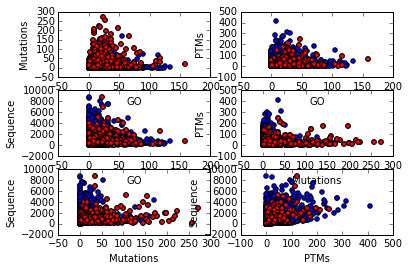

In [5]:
# create plots and calculate correlation
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
idxCol= 0
idxRow = 0
keys = df.columns
#pathoFilt = pathoStatus[indexes]
#%print len(pathoFilt)

if FILTER:
    dfFilt = df[(np.abs(stats.zscore(df)) < 20).all(axis=1)]
    indexes = df[(np.abs(stats.zscore(df)) < 20).all(axis=1)].index.tolist()
    pathoSFilt = pathoS[indexes]
    protIdsFilt = protId_S[indexes]
    df_path = dfFilt[:][pathoSFilt==1]
    df = dfFilt
    pathoS = pathoSFilt
    protId_S = protIdsFilt
    protId_pathoS = protId_S[pathoSFilt==1]
else:
    df_path = df[:][pathoS==1]  
    protId_pathoS = protId_S[pathoS==1]

  
for i in range(0, len(keys)):
    key1 = keys[i]
    for j in range(i+1, len(keys)):
        key2 = keys[j]
        #print "Comparing %s to %s"%(key1,key2)
        axes[idxRow, idxCol].scatter(df[key1], df[key2])
        axes[idxRow, idxCol].scatter(df[key1][pathoS==1], df[key2][pathoS==1], c='r')
        axes[idxRow, idxCol].set_xlabel(key1)
        axes[idxRow, idxCol].set_ylabel(key2)
        idxCol = idxCol+1
        #print "%d"%(idxCol % (nrows-1))
        if idxCol % (nrows-1) == 0:
            idxCol = 0
            idxRow += 1

df_path.describe()
df_path.sum()

# Correlation across all data

In [6]:
rArr = []
pArr = []
keys = df.columns
s = ''
for i in range(0, len(keys)):
    key1 = keys[i]
    for j in range(i+1, len(keys)):
        key2 = keys[j]
        [r, p] = stats.pearsonr(df[key1], df[key2])
        rArr.append(r)
        pArr.append(p)
        s = "%s%s and %s have correlation \t%0.2f with pvalue of %0.E\n"%(s, key1, key2, r, p)
print s
        

GO and Mutations have correlation 	0.22 with pvalue of 1E-230
GO and PTMs have correlation 	0.27 with pvalue of 0E+00
GO and Sequence have correlation 	0.04 with pvalue of 1E-10
Mutations and PTMs have correlation 	0.14 with pvalue of 5E-101
Mutations and Sequence have correlation 	0.19 with pvalue of 2E-172
PTMs and Sequence have correlation 	0.47 with pvalue of 0E+00



In [7]:
df.corr()

,GO,Mutations,PTMs,Sequence
GO,1.000000,0.216437,0.274569,0.043585
Mutations,0.216437,1.000000,0.143415,0.187399
PTMs,0.274569,0.143415,1.000000,0.471995
Sequence,0.043585,0.187399,0.471995,1.000000


# Correlation among pathogenic proteins

In [8]:
df_path.corr()


,GO,Mutations,PTMs,Sequence
GO,1.000000,0.160821,0.279432,0.103423
Mutations,0.160821,1.000000,0.151336,0.272401
PTMs,0.279432,0.151336,1.000000,0.512289
Sequence,0.103423,0.272401,0.512289,1.000000


In [9]:
# Check to see if there is enrichment in set of proteins with pathogenic mutations for 
# increased likelihood of having other annotations

N = len(df['Sequence'])
n = len(df_path['Sequence'])
keys = df.columns
numThreshold = range(0, 30, 5)
for j in numThreshold:
    print "\nThreshold for terms > %d"%(j)
    for i in range(0, len(keys)-1):
   
        K_list = df[df[keys[i]]>j]
        k_list = df_path[df_path[keys[i]]>j]
        K = len(K_list[keys[i]])
        k = len(k_list[keys[i]])
        oddsratio, pvalue = stats.fisher_exact([[k, n-k], [K, N-K]], alternative='greater')
     
        print "%s:\t\t %0.E \t(N=%d, n=%d, K=%d, k=%d)"%(keys[i], pvalue, N, n, K, k)

    


Threshold for terms > 0
GO:		 7E-97 	(N=21910, n=795, K=15480, k=783)
Mutations:		 1E-213 	(N=21910, n=795, K=11641, k=795)
PTMs:		 1E+00 	(N=21910, n=795, K=21910, k=795)

Threshold for terms > 5
GO:		 1E-130 	(N=21910, n=795, K=10057, k=697)
Mutations:		 0E+00 	(N=21910, n=795, K=2437, k=602)
PTMs:		 1E-20 	(N=21910, n=795, K=12858, k=594)

Threshold for terms > 10
GO:		 5E-100 	(N=21910, n=795, K=6041, k=513)
Mutations:		 1E-322 	(N=21910, n=795, K=1084, k=444)
PTMs:		 9E-21 	(N=21910, n=795, K=8506, k=441)

Threshold for terms > 15
GO:		 2E-70 	(N=21910, n=795, K=3509, k=344)
Mutations:		 3E-266 	(N=21910, n=795, K=665, k=345)
PTMs:		 6E-20 	(N=21910, n=795, K=5957, k=338)

Threshold for terms > 20
GO:		 2E-55 	(N=21910, n=795, K=2176, k=243)
Mutations:		 3E-214 	(N=21910, n=795, K=460, k=271)
PTMs:		 9E-15 	(N=21910, n=795, K=4358, k=252)

Threshold for terms > 25
GO:		 1E-48 	(N=21910, n=795, K=1414, k=183)
Mutations:		 1E-186 	(N=21910, n=795, K=359, k=231)
PTMs:		 1E-12 	(N=21

In [10]:
pickle.dump([df_path, protId_pathoS], open("pathoProteins.p", "w"))